## Brainstorming
#### Analysis Questions 
- How many temperature readings in each month seemed inaccurate
    - I defined the outliers as being 2 standard deviations above or below the mean
- Relationship between solar radiation and rainfall for each month
- Relationship between solar radiation and max temperature for each month 
- One table showing the mean of specific attributes for each month 

#### Data Quality Assessment
- **First**:
    - Renaming all the columns to a shorter, simplified name
    - Needing to use `FAWN_raw.columns = FAWN_raw.columns.str.strip()` to make all the white spaces between letters, numbers, or symbols single spaces so all the spaces are uniform  
- Check data types using `.info()`
    - displays: Column names, types, non-null counts, memory
- Check statistical description using `.describe()`  
- Use `.value_counts()` for frequency count of each category (**need to do**)
- Finding outliers for max and min temperatures   
    - find `std()` for max and min temperatures, by month, for all three years using `groupby()`  



## EDA Workflow


### Load and Initial Reconnaissance


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# loading Dataset from a CSV file #
FAWN_raw_initial = pd.read_csv("data/FAWN_report.csv")
FAWN_raw = pd.read_csv("data/FAWN_report.csv", parse_dates=["Period"], date_format="%d-%b-%y")
FAWN_clean = FAWN_raw
# FAWN_raw_spaces = FAWN_raw.columns.tolist()

# Cleaning spaces in raw data set
FAWN_clean.columns = FAWN_raw.columns.str.replace("  ", " ")

# Quality Assessment
FAWN_clean.describe()
FAWN_clean_loc_counts = FAWN_clean['FAWN Station'].value_counts()
FAWN_clean_loc = FAWN_clean['FAWN Station'].unique()
print(f"\n{FAWN_clean.dtypes}\n{FAWN_clean.info()}\n\n{FAWN_clean_loc_counts}\n")
print(f"{FAWN_clean_loc}\n\nThere are {len(FAWN_clean_loc)} weather stations represented in this DataFrame.\n")
print(f"Shape/dimensions of DataFrame: {FAWN_clean.shape}\n")
print(f"Number of Elements: {FAWN_clean.size}\n")

FAWN_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6572 entries, 0 to 6571
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   FAWN Station                 6572 non-null   object        
 1   Period                       6572 non-null   datetime64[ns]
 2   2m T avg (F)                 6572 non-null   float64       
 3   2m T min (F)                 6572 non-null   float64       
 4   2m T max (F)                 6572 non-null   float64       
 5   2m DewPt avg (F)             6572 non-null   float64       
 6   RelHum avg 2m (pct)          6572 non-null   int64         
 7   2m Rain tot (in)             6572 non-null   float64       
 8   2m Rain max over 15min (in)  6572 non-null   float64       
 9   SolRad avg2m (w/m^2)         6572 non-null   float64       
 10  10m Wind avg (mph)           6572 non-null   float64       
 11  10m Wind min (mph)           6572 non-null 

,FAWN Station,Period,2m T avg (F),2m T min (F),2m T max (F),2m DewPt avg (F),RelHum avg 2m (pct),2m Rain tot (in),2m Rain max over 15min (in),SolRad avg2m (w/m^2),10m Wind avg (mph),10m Wind min (mph),10m Wind max (mph),WDir avg10m (deg),BP avg (mb),N (# obs),2m WetBulb (F)
0,Apopka,2022-01-01,73.40,66.40,82.40,65.34,78,0.00,0.00,156.50,4.29,0.00,17.83,196,1014,96,67.97
1,Apopka,2022-01-02,73.41,67.06,81.93,68.16,84,0.00,0.00,124.04,5.42,0.13,18.36,221,1013,96,69.80
2,Apopka,2022-01-03,61.63,47.97,71.69,50.10,68,0.03,0.03,178.06,9.36,0.43,28.50,309,1016,96,55.06
3,Apopka,2022-01-04,58.21,43.94,72.05,51.42,80,0.00,0.00,144.97,5.12,0.05,16.96,39,1019,96,54.32
4,Apopka,2022-01-05,62.97,54.84,74.03,58.64,87,0.00,0.00,116.53,4.12,0.02,14.23,353,1014,96,60.27


#### Analysis worth exploring (can subtract from if needed)
- The following columns could answer my questions:
  - minimum and maximum temperature (F)
  - dew point, relative humidity
  - maximum rainfall
  - minimum and maximum wind (mph)
  - wind direction (deg)
  - number of observations
#### Analysis Questions 
- How many temperature readings in each month seemed inaccurate or could be classified as outliers?
- Relationship between solar radiation and rainfall for each month
- Relationship between solar radiation and max temperature for each month
- One table showing the mean of specific attributes for each month


### Data Quality Assessment 
- The column names were in a scattered format and hard to read:
    - Renamed the columns to a more readable format
- The `N (# obs)` column could be worth exploring for accuracy purposes
  - Using `value_counts()`, displays the number of observations for each data value
  - This data is largely valid because the vast majority of individual days have 96 observations
    - *For reference*: The assumption is that data is collected every 15 minutes for 24 hours
    - This means that the columns with *average values* should be averaged over 24 hours in 15-minute intervals 
- All of the `dtypes` displayed above are accurate, and the DataFrame appears not to have any NaN values when comparing the result of `dtypes` to the `shape` of the DataFrame
- Used `groupby()` to separate the min temp by month and then used `quantile(0.5)`, which finds the temperature that 50% of the temperatures are above and below
- The columns: `2m Rain tot (in)` and `2m Rain max over 15min (in)` contain some values of 0
    - The count of these values can be found using `isin()` 
- Outliers can be determined with `between()`
  - could use by month 

### Data to graph 
- pie chart of `N_unique = FAWN_clean['N (# obs)'].value_counts()` for `N (# obs)`

In [2]:

N_unique = FAWN_clean['N (# obs)'].value_counts()
print(f"{N_unique}") 

#FAWN_clean['FAWN Station'].between()
# Grouping min temp by month to find quantile %s
FAWN_clean['Month'] = FAWN_clean['Period'].dt.month_name() 
#FAWN_clean['2m T min (F)'].quantile(0.5)
monthyly_T_min = FAWN_clean.groupby('Month')['2m T min (F)']
monthyly_T_min.quantile(0.5) 

zero_rain_Monthcount = FAWN_clean[FAWN_clean['2m Rain tot (in)'] == 0].groupby(['Month', 'FAWN Station']).size().unstack()
print(f"\nNumber of non-rainy days categorized by month: \n\n{zero_rain_Monthcount}\n")

rain_Monthcount = FAWN_clean[FAWN_clean['2m Rain tot (in)'] != 0].groupby(['Month', 'FAWN Station']).size().unstack()
print(f"\nNumber of rainy days categorized by month: \n\n{rain_Monthcount}\n") 

non_rainyDays = FAWN_clean[FAWN_clean['2m Rain tot (in)'].isin([0])]
rainyDays = FAWN_clean[~FAWN_clean['2m Rain tot (in)'].isin([0])]
print(f"\nNumber of rainy days: {len(rainyDays['2m Rain tot (in)'])}\n")
print(f"Number of non-rainy days: {len(non_rainyDays['2m Rain tot (in)'])}\n")

N_outliers = rain_Monthcount.index[5] 
N_outliers

N (# obs)
96    6497
95      47
93      13
92       7
94       2
87       1
13       1
55       1
81       1
82       1
83       1
Name: count, dtype: int64

Number of non-rainy days categorized by month: 

FAWN Station  Apopka  DeFuniak Springs  Homestead  Jay  Live Oak  Monticello
Month                                                                       
April             69                61         65   65        62          63
August            41                52         35   60        47          42
December          68                59         66   63        71          75
February          67                64         66   59        65          64
January           65                56         64   57        64          57
July              37                39         36   32        36          39
June              51                53         26   47        51          58
March             69                66         71   60        63          59
May               63   

'July'

### Cleaning Decisions 
- Reformatting and renaming columns
- In data quality assessment, we evaluated the `N (# obs)` cloumn by using `value_counts`
  - Based on the results, if the number of observations was below 87, this meant that these values were less than 90%` of the maximum number of observations, 96, and therefore they could skew the results and be labeled as **legitimate outliers** 
  - For this reason, we decided to remove these values
  - Used indexing to remove outliers
  - `FAWN_clean = FAWN_clean[FAWN_clean['N_obs'] >= 87]`
- Removing a total of 5 outliers based on observation values in the `N (# obs)` column introduces little bias because there are over 6500 total observations 

In [3]:

# Renaming columns
FAWN_clean.rename(
    columns={
        "FAWN Station": "FAWN Station",
        "Period": "Period",
        "2m T avg (F)": "Temp_avg (F)",
        "2m T min (F)": "T_min (F)",
        "2m T max (F)": "T_max (F)",
        "2m DewPt avg (F)": "DewPt_avg (F)",
        "RelHum avg 2m (pct)": "RelHum_avg (pct)",
        "2m Rain tot (in)": "Rain_tot (in)",
        "2m Rain max over 15min (in)": "Rain_max over 15min (in)",
        "SolRad avg2m (w/m^2)": "SolRad_avg @ 2m (w/m^2)",
        "10m Wind avg (mph)": "Wind_avg @ 10m (mph)",
        "10m Wind min (mph)": "Wind_min @ 10m (mph)",
        "10m Wind max (mph)": "Wind_max @ 10m (mph)",
        "WDir avg10m (deg)": "Wind_Dir_avg @ 10m (deg)",
        "BP avg (mb)": "Barametric_Pre_avg (mb)",
        "N (# obs)": "N_obs",
        "2m WetBulb (F)": "WetBulb @ 2m (F)",
    },
    inplace=True,
)

# FAWN_raw = FAWN_raw.replace('0', np.nan)
pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)

# print(f"{FAWN_clean.isna().sum()}\n")
# print(f"{FAWN_raw_spaces}\n")
# print(f"{FAWN_raw.columns}\n")

# Removing legitimate outliers from the N (# obs) column 
#N_outliers = FAWN_clean.query('`N_obs` < 87') 
#N_outliers = FAWN_clean[FAWN_clean['N_obs'] < 87] 
#print(N_outliers)
FAWN_clean = FAWN_clean[FAWN_clean['N_obs'] >= 87]
print(f"Observation outliers removed, shown by Shape of DataFrame.\nNew shape: {FAWN_clean.shape}\n")

#df.query('price > @min_price and quantity < 100') 
FAWN_clean.head()


Observation outliers removed, shown by Shape of DataFrame.
New shape: (6567, 18)



,FAWN Station,Period,Temp_avg (F),T_min (F),T_max (F),DewPt_avg (F),RelHum_avg (pct),Rain_tot (in),Rain_max over 15min (in),SolRad_avg @ 2m (w/m^2),Wind_avg @ 10m (mph),Wind_min @ 10m (mph),Wind_max @ 10m (mph),Wind_Dir_avg @ 10m (deg),Barametric_Pre_avg (mb),N_obs,WetBulb @ 2m (F),Month
0,Apopka,2022-01-01,73.40,66.40,82.40,65.34,78,0.00,0.00,156.50,4.29,0.00,17.83,196,1014,96,67.97,January
1,Apopka,2022-01-02,73.41,67.06,81.93,68.16,84,0.00,0.00,124.04,5.42,0.13,18.36,221,1013,96,69.80,January
2,Apopka,2022-01-03,61.63,47.97,71.69,50.10,68,0.03,0.03,178.06,9.36,0.43,28.50,309,1016,96,55.06,January
3,Apopka,2022-01-04,58.21,43.94,72.05,51.42,80,0.00,0.00,144.97,5.12,0.05,16.96,39,1019,96,54.32,January
4,Apopka,2022-01-05,62.97,54.84,74.03,58.64,87,0.00,0.00,116.53,4.12,0.02,14.23,353,1014,96,60.27,January


### Statistical EDA
- `.describe()` is used to display descriptive statistics of each column with numerical values
  - `.drop()` excludes columns containing strings 


In [4]:
# Displaying descriptive statistics of each column with numerical values 
print(f"{FAWN_clean.drop(columns=['FAWN Station','Period']).describe().T}\n")

#print(f"{FAWN_clean.groupby(['FAWN Station', 'Month']).describe().T}") 

# Finding min temp outliers by month 
FAWN_clean["Month"] = FAWN_clean['Period'].dt.month_name()
monthyly_std_T_min = FAWN_clean.groupby(["Month"])["T_min (F)"].std() * 2
monthyly_mean_T_min = FAWN_clean.groupby(["Month"])["T_min (F)"].mean()
print(f"Two times Std: \n{monthyly_std_T_min}\n")
print(f"Mean of each month: \n{monthyly_mean_T_min}\n")

# Creating a separate column for Days
FAWN_clean["Day"] = FAWN_clean['Period'].dt.day_name()
# daily_T_min_byMonth = FAWN_clean.groupby('Month').agg({'Day':

# Calculating two std dev values above and below the mean for each month
two_std_overMean = monthyly_std_T_min + monthyly_mean_T_min
two_std_underMean = monthyly_mean_T_min - monthyly_std_T_min
print(f"Two std above Mean: \n{two_std_overMean}\n")
print(f"Two std below Mean: \n{two_std_underMean}\n")

"""FAWN_clean.merge(
    two_std_underMean.rename('Two std above Temp_min Mean'), 
    left_on=FAWN_clean['Month'], 
    right_index=True, 
    how='left'
)"""

# Adding two std dev values above and below the mean for each month
FAWN_clean["Two std above Temp_min Mean"] = FAWN_clean["Month"].map(two_std_overMean)
FAWN_clean["Two std below Temp_min Mean"] = FAWN_clean["Month"].map(two_std_underMean)

# Setting Period as index
#FAWN_clean = FAWN_clean.reset_index()
#FAWN_clean = FAWN_clean.set_index('Period')


# Finding Outliers
Temp_min_outlier = FAWN_clean[
    (FAWN_clean["T_min (F)"] > FAWN_clean["Two std above Temp_min Mean"])
    | (FAWN_clean["T_min (F)"] < FAWN_clean["Two std below Temp_min Mean"])
]
# print(Temp_min_outlier.count())

#FAWN_clean.groupby()
#print(f"\nNumber of outliers: \n{Temp_min_outlier['T_min (F)']}")
FAWN_clean

                           count         mean         std     min       25%      50%       75%      max
Temp_avg (F)              6567.0    69.864713   11.085332   23.95    63.755    72.53    78.595    88.27
T_min (F)                 6567.0    60.716230   12.877607   16.56    52.460    64.18    71.370    81.45
T_max (F)                 6567.0    80.822555   10.742570   32.55    74.550    83.03    89.110   100.99
DewPt_avg (F)             6567.0    62.526093   12.800557  -32.22    55.455    66.12    72.880    79.53
RelHum_avg (pct)          6567.0    79.924014    9.701979    0.00    74.000    81.00    87.000   100.00
Rain_tot (in)             6567.0     0.164602    0.506077    0.00     0.000     0.00     0.045     9.90
Rain_max over 15min (in)  6567.0     0.056382    0.149277    0.00     0.000     0.00     0.020     1.50
SolRad_avg @ 2m (w/m^2)   6567.0   188.756849   74.307345    4.01   139.555   191.00   244.600   380.16
Wind_avg @ 10m (mph)      6567.0     5.065043    2.391075    1.0

C:\Users\dzt0065\AppData\Local\Temp\ipykernel_13692\3866873549.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FAWN_clean["Month"] = FAWN_clean['Period'].dt.month_name()
C:\Users\dzt0065\AppData\Local\Temp\ipykernel_13692\3866873549.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FAWN_clean["Day"] = FAWN_clean['Period'].dt.day_name()
C:\Users\dzt0065\AppData\Local\Temp\ipykernel_13692\3866873549.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

,FAWN Station,Period,Temp_avg (F),T_min (F),T_max (F),DewPt_avg (F),RelHum_avg (pct),Rain_tot (in),Rain_max over 15min (in),SolRad_avg @ 2m (w/m^2),Wind_avg @ 10m (mph),Wind_min @ 10m (mph),Wind_max @ 10m (mph),Wind_Dir_avg @ 10m (deg),Barametric_Pre_avg (mb),N_obs,WetBulb @ 2m (F),Month,Day,Two std above Temp_min Mean,Two std below Temp_min Mean
0,Apopka,2022-01-01,73.40,66.40,82.40,65.34,78,0.00,0.00,156.50,4.29,0.00,17.83,196,1014,96,67.97,January,Saturday,70.130502,20.964587
1,Apopka,2022-01-02,73.41,67.06,81.93,68.16,84,0.00,0.00,124.04,5.42,0.13,18.36,221,1013,96,69.80,January,Sunday,70.130502,20.964587
2,Apopka,2022-01-03,61.63,47.97,71.69,50.10,68,0.03,0.03,178.06,9.36,0.43,28.50,309,1016,96,55.06,January,Monday,70.130502,20.964587
3,Apopka,2022-01-04,58.21,43.94,72.05,51.42,80,0.00,0.00,144.97,5.12,0.05,16.96,39,1019,96,54.32,January,Tuesday,70.130502,20.964587
4,Apopka,2022-01-05,62.97,54.84,74.03,58.64,87,0.00,0.00,116.53,4.12,0.02,14.23,353,1014,96,60.27,January,Wednesday,70.130502,20.964587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6567,Monticello,2024-12-27,57.30,50.47,66.13,54.89,92,0.01,0.01,56.62,3.41,0.02,15.21,81,1016,96,55.87,December,Friday,73.071414,23.456221
6568,Monticello,2024-12-28,68.63,62.62,76.86,65.50,90,0.00,0.00,73.52,3.19,0.05,16.62,144,1014,96,66.53,December,Saturday,73.071414,23.456221
6569,Monticello,2024-12-29,66.48,59.56,70.38,64.05,92,0.53,0.29,44.44,3.47,0.02,17.58,186,1009,96,64.88,December,Sunday,73.071414,23.456221
6570,Monticello,2024-12-30,57.85,46.51,74.53,51.98,83,0.00,0.00,151.36,1.32,0.00,8.95,194,1009,96,54.47,December,Monday,73.071414,23.456221


#### Histogram of Minimum Temp values **by** month
- Graph the minimum temperature value for each day by month
- Should give you 12 graphs 
    - Label two std deviations above **and** below the mean on **each** graph 
- `Temp_min_outlier = FAWN_clean[ (FAWN_clean["T_min (F)"] > FAWN_clean["Two std above Temp_min Mean"])
    | (FAWN_clean["T_min (F)"] < FAWN_clean["Two std below Temp_min Mean"])]`
    - Try to use this variable, `Temp_min_outlier`, to highlight the outliers on the graph 


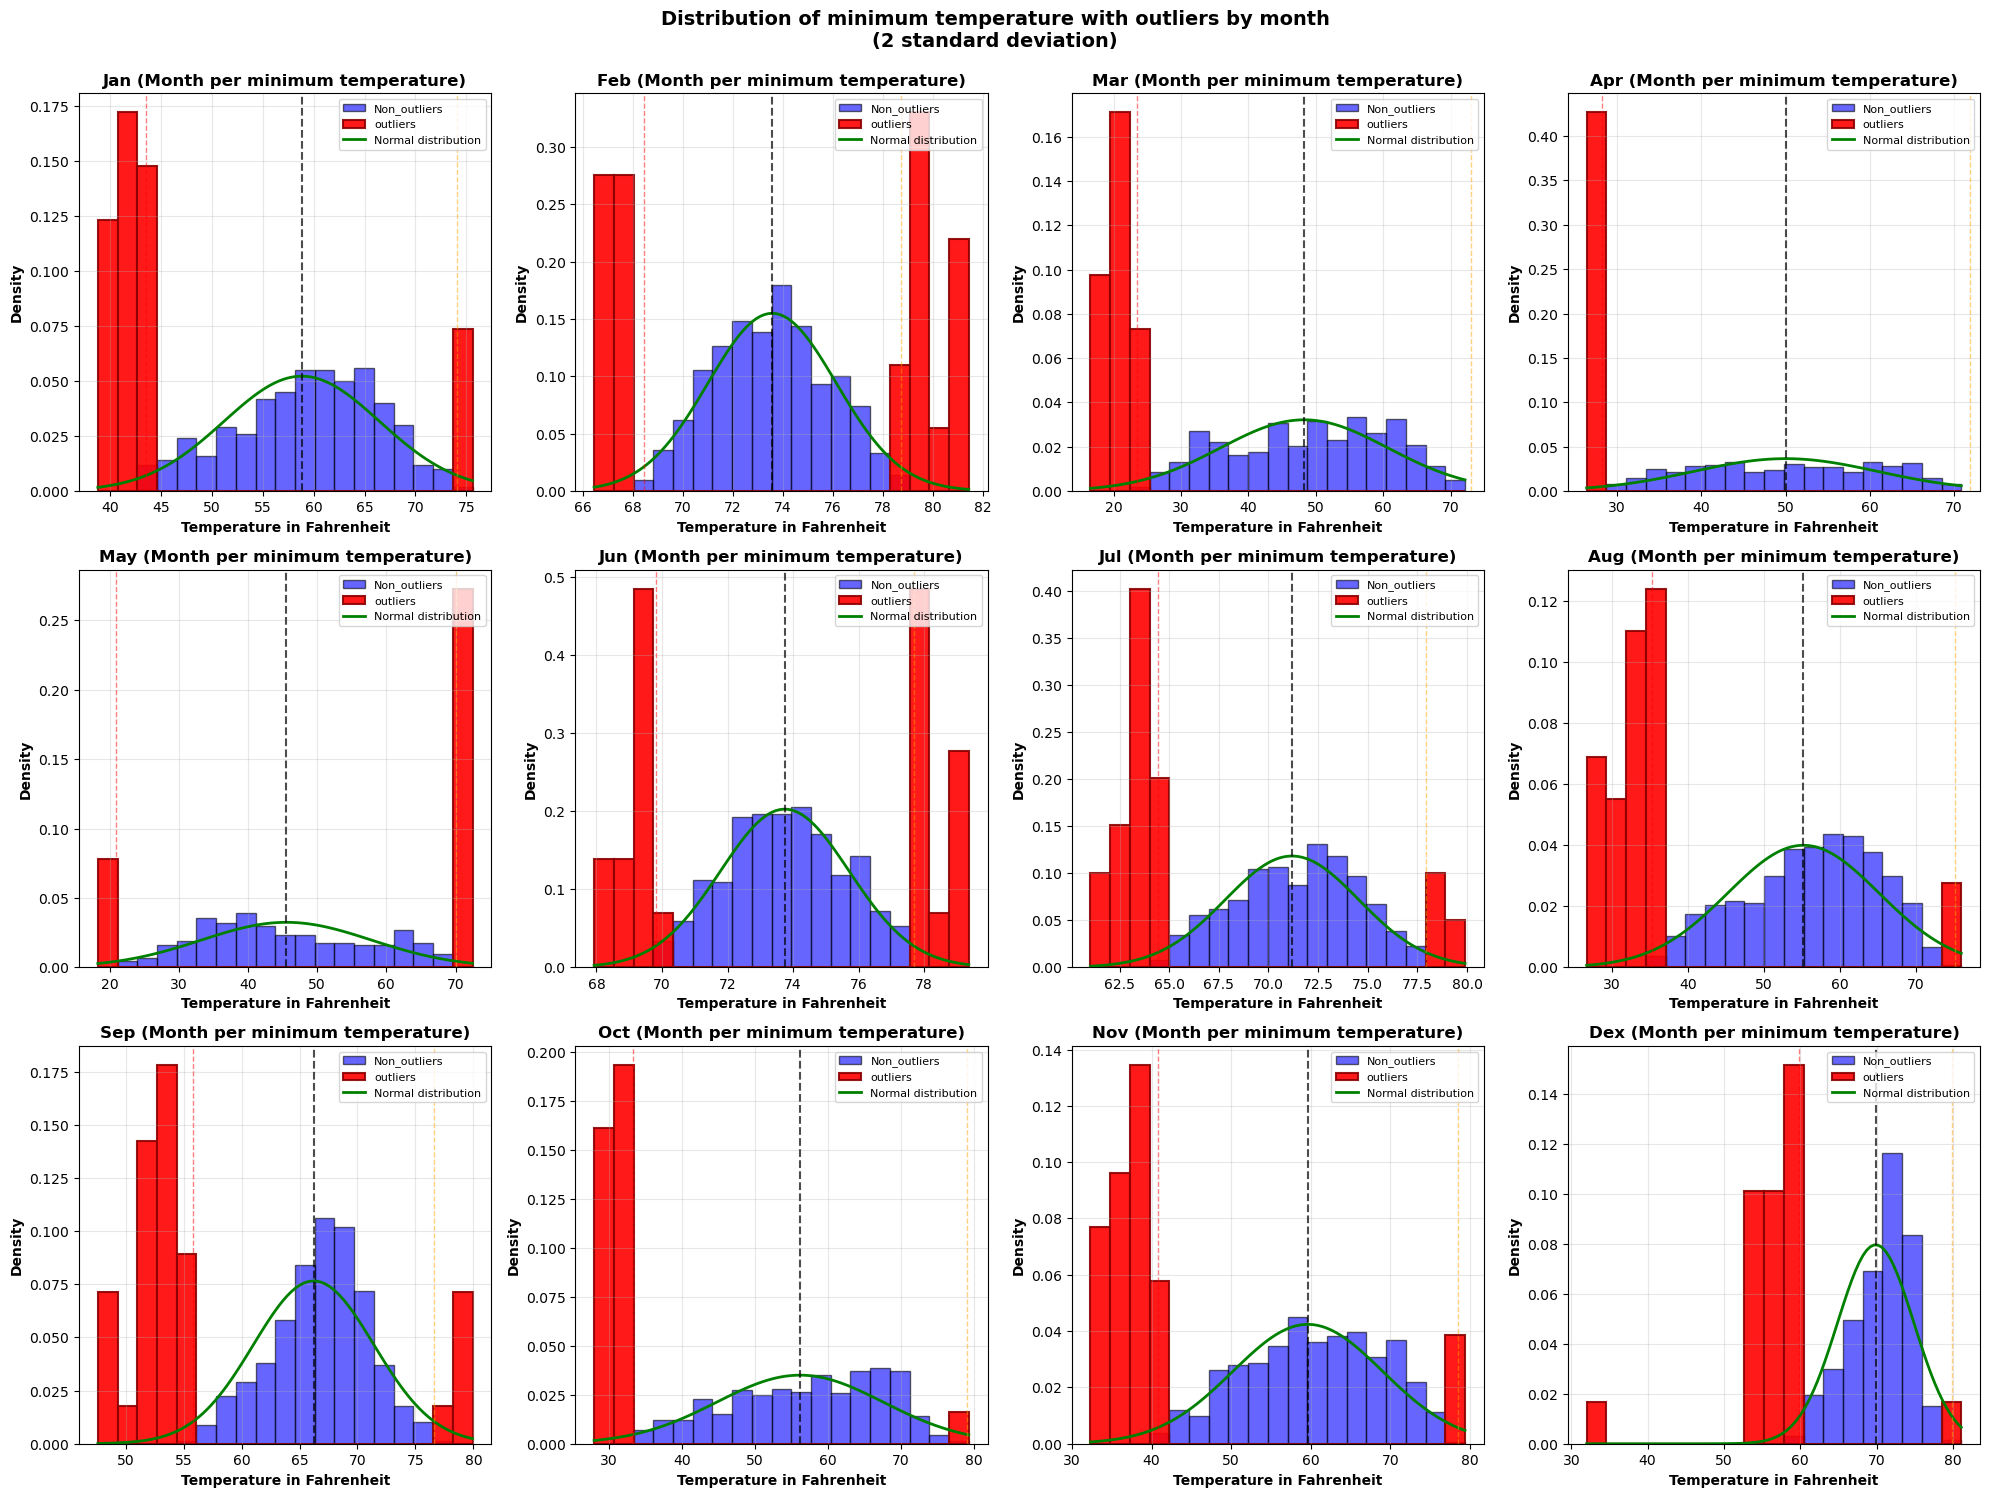

In [5]:
# To create a column for the Temp_min_outlier for the entire dataset
# calculate the 2 standard deviation boundaries for each month
monthly_stat = FAWN_clean.groupby("Month")["T_min (F)"].agg(["mean", "std"]).reset_index()
monthly_stat["upper_bound"] = monthly_stat["mean"] + 2 * monthly_stat["std"]
monthly_stat["lower_bound"] = monthly_stat["mean"] - 2 * monthly_stat["std"]

# Let merge with the dataFrame
FAWN_clean = FAWN_clean.merge(
    monthly_stat[["Month", "upper_bound", "lower_bound"]],
    on="Month",
    how="left",
    suffixes=("", "_monthly"),
)

# finally, let us create the outlier column
FAWN_clean["Temp_min_outlier"] = (FAWN_clean["T_min (F)"] > FAWN_clean["upper_bound"]) | (
    FAWN_clean["T_min (F)"] < FAWN_clean["lower_bound"]
)


# To create the subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# To get unique months
months = FAWN_clean["Month"].unique()
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dex"]

# Now let's loop through each month
for idx, month in enumerate(sorted(months)):
    ax = axes[idx]

    # Filter data for this month
    month_data = FAWN_clean[FAWN_clean["Month"] == month].copy()

    # To get the temperature data
    temp_data = month_data["T_min (F)"].dropna()

    # To identify the outliers, i.e, values outside the 2 std from the mean
    outliers = month_data[month_data["Temp_min_outlier"] == True]["T_min (F)"].dropna()
    Non_outliers = month_data[month_data["Temp_min_outlier"] == False]["T_min (F)"].dropna()

    # To calculate the statistics
    mean_temp = temp_data.mean()
    std_temp = temp_data.std()

    # Now, let's create bins
    if len(temp_data) > 0:
        bin_edges = np.linspace(temp_data.min(), temp_data.max(), 20)

        # histogram plots for non-outliers and outliers
        ax.hist(
            Non_outliers,
            bins=bin_edges,
            alpha=0.6,
            color="blue",
            label="Non_outliers",
            density=True,
            edgecolor="black",
        )
        if len(outliers) > 0:
            ax.hist(
                outliers,
                bins=bin_edges,
                alpha=0.9,
                color="red",
                label="outliers",
                density=True,
                edgecolor="darkred",
                linewidth=1.5,
            )

            # let add normal distribution curve
            x = np.linspace(temp_data.min(), temp_data.max(), 100)
            normal_curve = stats.norm.pdf(x, mean_temp, std_temp)
            ax.plot(x, normal_curve, "green", linewidth=2, label="Normal distribution")

            # Let's add a vertical line for the mean
            ax.axvline(mean_temp, color="black", linestyle="--", linewidth=1.5, alpha=0.7)

            # Define the outliers and non-outliers
            upper_bound = mean_temp + 2 * std_temp
            lower_bound = mean_temp - 2 * std_temp
            ax.axvline(upper_bound, color="orange", linestyle="--", linewidth=1, alpha=0.5)
            ax.axvline(lower_bound, color="red", linestyle="--", linewidth=1, alpha=0.5)

        # Let label and give title to the plot's
        ax.set_xlabel("Temperature in Fahrenheit", fontsize=10, fontweight="bold")
        ax.set_ylabel("Density", fontsize=10, fontweight="bold")
        ax.set_title(
            f"{month_names[idx]} (Month per minimum temperature)", fontsize=12, fontweight="bold"
        )
        ax.legend(loc="upper right", fontsize=8)
        ax.grid(True, alpha=0.3)

plt.suptitle(
    "Distribution of minimum temperature with outliers by month\n(2 standard deviation)",
    fontsize=14,
    fontweight="bold",
    y=0.995,
)

plt.tight_layout()
plt.show()